In [100]:
import pandas as pd
pd.set_option("display.max_rows",None)             # to display ass row
pd.set_option("display.max_rows",None)             # to display ass columns

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
df = pd.read_csv(r"C:\Users\91752\OneDrive - DIT University\Desktop\ML projects\Email_spam\spam.csv", encoding="ISO-8859-1")

###    data cleaning    ###

In [105]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [106]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace=True)

In [107]:
df.rename(columns={"v1":"target","v2":"text"},inplace=True)

In [108]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [109]:
df['target'] = le.fit_transform(df['target'])

In [110]:
df.duplicated().sum()

403

In [111]:
df = df.drop_duplicates(keep="first")

In [112]:
df.shape

(5169, 2)

###    EDA    ###

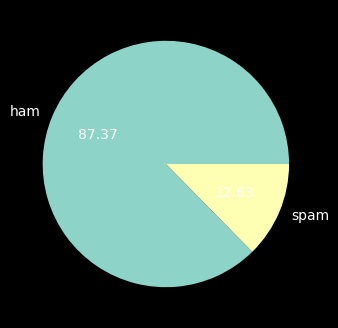

In [113]:
plt.figure(figsize=(4,4))
plt.gcf().set_facecolor('black')
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f",textprops={'color':'white'})
plt.show()

In [114]:
import nltk
#nltk.download('punkt')
#nltk.download('all')

In [115]:
df['num_charachters'] = df['text'].apply(len)

In [116]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [117]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [118]:
# ham mail
df[df['target']==0][["num_charachters","num_words","num_sentences"]].describe()

,num_charachters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [119]:
# spam mail
df[df['target']==1][["num_charachters","num_words","num_sentences"]].describe()

,num_charachters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


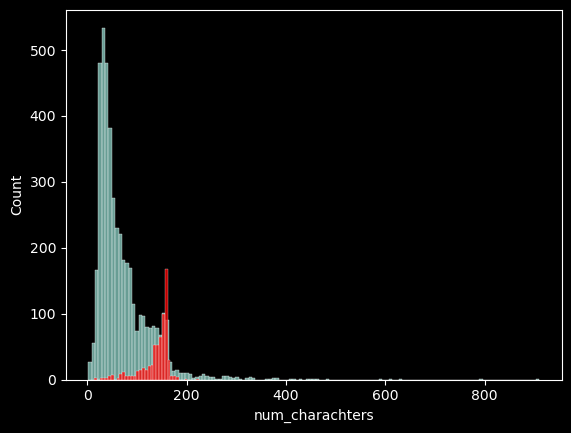

In [120]:
sns.histplot(df[df['target']==0]["num_charachters"])
sns.histplot(df[df['target']==1]["num_charachters"],color="red")
plt.show()

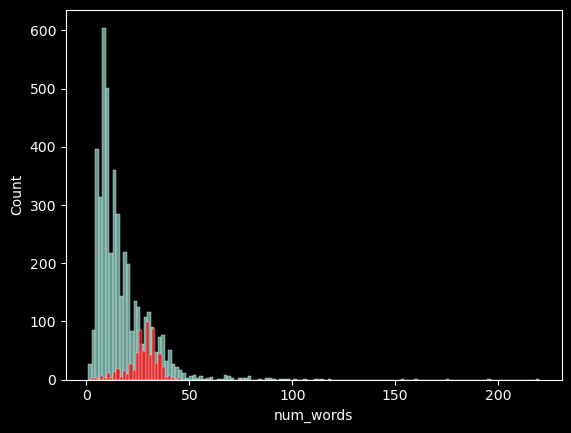

In [121]:
sns.histplot(df[df['target']==0]["num_words"])
sns.histplot(df[df['target']==1]["num_words"],color="red")
plt.show()

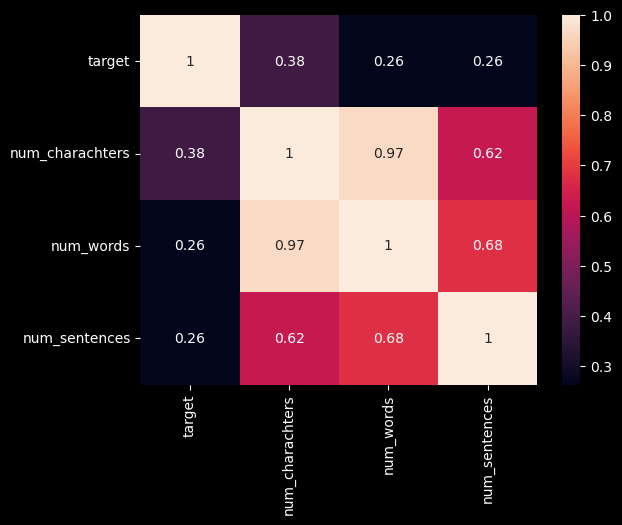

In [122]:
a = df.drop("text",axis=1)
sns.heatmap(a.corr(),annot=True)
plt.show()

###    text preprocessing    ###

In [123]:
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [124]:
import string
sp = string.punctuation

In [125]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [126]:
def transform_text(text):
    text = text.lower()                                              # lower case
    text = nltk.word_tokenize(text)                                  # word tokenize
    
    li =[]
    for i in text:                                                   # removing special charachter
        if i.isalnum():
            li.append(i)

    text = li[:]                                                     # making list empty
    li.clear()

    for i in text:                                                   # removing stop words and puntuations
        if i not in sw and i not in sp:
            li.append(i)

    text = li[:]
    li.clear()

    for i in text:                                                   # stemming of words
        ps.stem(i)
        li.append(i)
    
    return " ".join(li)

In [127]:
df['transformed_text'] = df['text'].apply(transform_text)

In [128]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color="black")

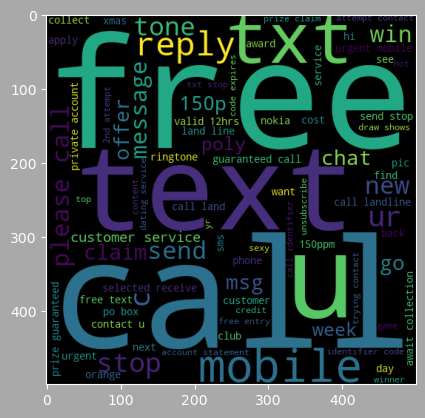

In [129]:
spam_wc = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)
plt.gcf().set_facecolor("darkgrey")

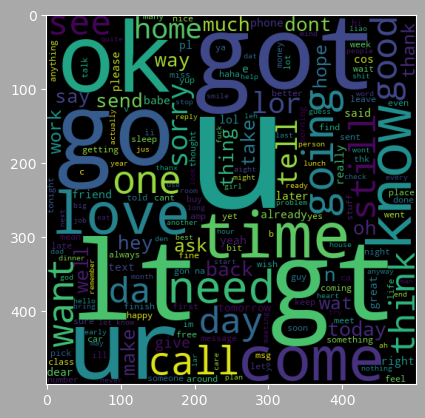

In [130]:
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep=" "))
plt.imshow(ham_wc)
plt.gcf().set_facecolor("darkgrey")

In [131]:
from collections import Counter

In [132]:
spam_corpus=[]
for msg in df[df['target']==1]['transformed_text'].tolist() :
    for words in msg.split():
        spam_corpus.append(words)

In [133]:
Counter(spam_corpus).most_common(3)

[('call', 302), ('free', 191), ('2', 155)]

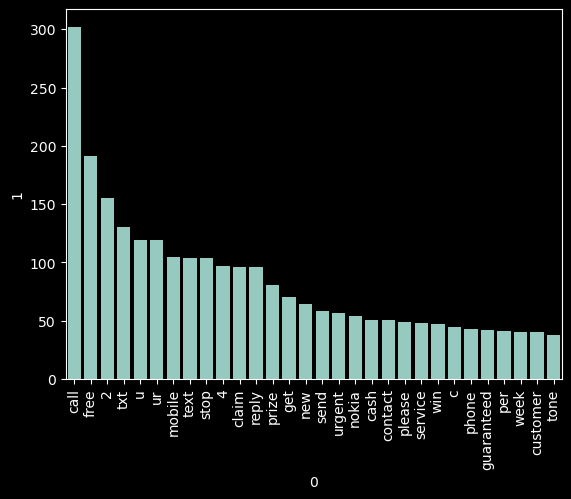

In [134]:
plt.style.use("dark_background")
sns.barplot(x = pd.DataFrame(Counter(spam_corpus).most_common(30))[0],y = pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [135]:
ham_corpus=[]
for msg in df[df['target']==0]['transformed_text'].tolist() :
    for words in msg.split():
        ham_corpus.append(words)

In [136]:
mail = pd.DataFrame(Counter(ham_corpus).most_common(30),columns=["text","count"])

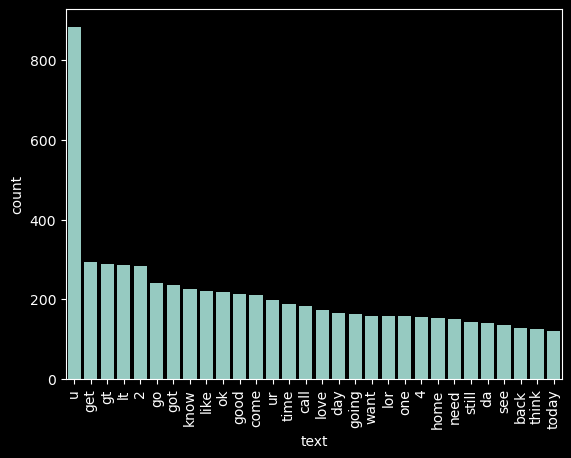

In [137]:
plt.style.use("dark_background")
sns.barplot(x = "text",y = "count",data = mail)
plt.xticks(rotation='vertical')
plt.show()

###    model building    ###

In [138]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer                     # vectorization
cv = CountVectorizer()
tv = TfidfVectorizer(max_features=3000)                                                         # max_feature

In [140]:
# can try on any one (x)

#x = cv.fit_transform(df['transformed_text']).toarray()

x = tv.fit_transform(df['transformed_text']).toarray()


In [141]:
y = df['target'].values

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix , recall_score

In [143]:
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [144]:
### imbalanced data

from imblearn.over_sampling import RandomOverSampler

ro = RandomOverSampler()
x , y = ro.fit_resample(x,y)

In [145]:

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.15, random_state = 42)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.4, random_state = 42)

In [146]:
x_train.shape, x_test.shape, x_val.shape

((7677, 3000), (813, 3000), (542, 3000))

In [147]:
gnb.fit(x_train,y_train)
y_pred = gnb.predict(x_test)
print(accuracy_score(y_test,y_pred), "\n")
print(confusion_matrix(y_test,y_pred), "\n")
print(precision_score(y_test,y_pred), "\n")
print(gnb.score(x_test,y_test),",",gnb.score(x_train,y_train))

0.9372693726937269 

[[324  51]
 [  0 438]] 

0.8957055214723927 

0.9372693726937269 , 0.9392992054187834


In [148]:
bnb.fit(x_train,y_train)
y_pred = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred), "\n")
print(confusion_matrix(y_test,y_pred), "\n")
print(precision_score(y_test,y_pred), "\n")
print(bnb.score(x_test,y_test),",",bnb.score(x_train,y_train))

0.968019680196802 

[[373   2]
 [ 24 414]] 

0.9951923076923077 

0.968019680196802 , 0.9757717858538492


In [149]:
mnb.fit(x_train,y_train)
y_pred = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred), "\n")
print(confusion_matrix(y_test,y_pred), "\n")
print(precision_score(y_test,y_pred), "\n")
print(recall_score(y_test, y_pred), "\n")
print(mnb.score(x_test,y_test),",",mnb.score(x_train,y_train))

0.9704797047970479 

[[366   9]
 [ 15 423]] 

0.9791666666666666 

0.9657534246575342 

0.9704797047970479 , 0.971733750162824


# testing with various algorithms for better result

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [181]:
# without max feature
svc = SVC(kernel="sigmoid",gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear',penalty='l1')
rfc = RandomForestClassifier(n_estimators=50,random_state=2)
abc = AdaBoostClassifier(n_estimators=50,random_state=2)
bc = BaggingClassifier(n_estimators=50,random_state=2)
etc = ExtraTreesClassifier(n_estimators=50,random_state=2)
gbt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xbg = XGBClassifier(n_estimators=50,random_state=2)


# with max feature
"""svc = SVC(kernel="sigmoid", gamma=1.0)  # No max_features
knc = KNeighborsClassifier()  # No max_features
mnb = MultinomialNB()  # No max_features
dtc = DecisionTreeClassifier(max_depth=5, max_features="sqrt")  # Supports max_features
lr = LogisticRegression(solver='liblinear', penalty='l1')  # No max_features
rfc = RandomForestClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features
abc = AdaBoostClassifier(n_estimators=50, random_state=2)  # No max_features
bc = BaggingClassifier(n_estimators=50, random_state=2, max_features=0.5)  # Supports max_features
etc = ExtraTreesClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features
gbt = GradientBoostingClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features
xbg = XGBClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features"""

'svc = SVC(kernel="sigmoid", gamma=1.0)  # No max_features\nknc = KNeighborsClassifier()  # No max_features\nmnb = MultinomialNB()  # No max_features\ndtc = DecisionTreeClassifier(max_depth=5, max_features="sqrt")  # Supports max_features\nlr = LogisticRegression(solver=\'liblinear\', penalty=\'l1\')  # No max_features\nrfc = RandomForestClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features\nabc = AdaBoostClassifier(n_estimators=50, random_state=2)  # No max_features\nbc = BaggingClassifier(n_estimators=50, random_state=2, max_features=0.5)  # Supports max_features\netc = ExtraTreesClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features\ngbt = GradientBoostingClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features\nxbg = XGBClassifier(n_estimators=50, random_state=2, max_features="sqrt")  # Supports max_features'

In [182]:
clfs = {
    'svc':svc,
    'mnb':mnb,
    'knc':knc,
    'dtc':dtc,
    'lr':lr,
    'rfc':rfc,
    'abc':abc,
    'bc':bc,
    'etc':etc,
    'gdt':gbt,
    'xbg':xbg
       }

In [183]:
def train_classifier(clf,x_train,x_test,y_train,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    test = clf.score(x_test,y_test)
    train = clf.score(x_train,y_train)
    precision = precision_score(y_test,y_pred)

    return train,test,precision

In [ ]:
train_li = []
test_li = []
precision_li =[]

for name,clf in clfs.items():
    
    train, test, precision  = train_classifier(clf,x_train,x_test,y_train,y_test)

    train_li.append(train)
    test_li.append(test)
    precision_li.append(precision)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
score_df = pd.DataFrame({'Algorithm':clfs.keys(), 'train_score':train_li, 'test_score':test_li, 'precision_score':precision_li})
score_df = score_df.sort_values(by=['precision_score','test_score'],ascending=False).reset_index(drop=True)
score_df

In [54]:
#score_max_df = pd.DataFrame({'Algorithm':clfs.keys(), 'train_score':train_li, 'test_score':test_li, 'precision_score':precision_li})

In [55]:
#score_scaling_df = pd.DataFrame({'Algorithm':clfs.keys(), 'train_score':train_li, 'test_score':test_li, 'precision_score':precision_li})

<function matplotlib.pyplot.show(close=None, block=None)>

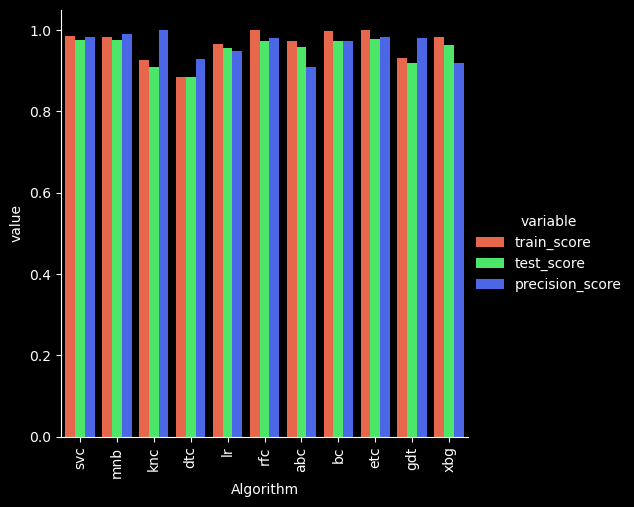

In [56]:
score_df1 = pd.melt(score_df, id_vars = "Algorithm")

sns.catplot(x = "Algorithm", y = "value", data = score_df1, kind = "bar", hue = "variable", palette=["#FF5733", "#33FF57", "#3357FF"])
plt.xticks(rotation = "vertical")
plt.show

# final model 

In [154]:
# enter your mail here

text = """Free Msg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
"""  

transformed_text = transform_text(text)
a = tv.transform(['transformed_text']).toarray()

In [88]:
i = 2 

a = x_val[[i]]
b = y_val[i]
b

1

In [155]:

prediction = mnb.predict(a)
if prediction == 0 :
    print("this email is not a spam email")
else : 
    print("this email is  a spam email")

this email is not a spam email


In [156]:
print(transform_text(text))

free msg hey darling 3 week word back like fun still tb ok xxx std chgs send rcv


# simple

In [157]:
import pandas as pd
pd.set_option("display.max_rows",None)             # to display ass row
pd.set_option("display.max_rows",None)             # to display ass columns

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer                     # vectorization

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix , recall_score

In [166]:
df = pd.read_csv(r"C:\Users\91752\OneDrive - DIT University\Desktop\ML projects\Email_spam\spam.csv", encoding="ISO-8859-1")

In [167]:
df.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace=True)
df.rename(columns={"v1":"target","v2":"text"},inplace=True)

In [168]:
le = LabelEncoder()

df['target'] = le.fit_transform(df['target'])

df = df.drop_duplicates(keep="first")

In [169]:

sw = stopwords.words("english")

sp = string.punctuation

ps = PorterStemmer()

def transform_text(text):
    text = text.lower()                                              # lower case
    text = nltk.word_tokenize(text)                                  # word tokenize
    
    li =[]
    for i in text:                                                   # removing special charachter
        if i.isalnum():
            li.append(i)

    text = li[:]                                                     # making list empty
    li.clear()

    for i in text:                                                   # removing stop words and puntuations
        if i not in sw and i not in sp:
            li.append(i)

    text = li[:]
    li.clear()

    for i in text:                                                   # stemming of words
        ps.stem(i)
        li.append(i)
    
    return " ".join(li)

df['transformed_text'] = df['text'].apply(transform_text)

In [170]:
cv = CountVectorizer()
tv = TfidfVectorizer(max_features=3000)  

# can try on any one (x)

x = cv.fit_transform(df['transformed_text']).toarray()

#x = tv.fit_transform(df['transformed_text']).toarray()

y = df['target'].values

ro = RandomOverSampler()
x , y = ro.fit_resample(x,y)

In [171]:

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.15, random_state = 42)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.4, random_state = 42)

x_train.shape, x_test.shape, x_val.shape

((7677, 8002), (813, 8002), (542, 8002))

In [172]:
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

In [173]:
mnb.fit(x_train,y_train)
y_pred = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred), "\n")
print(confusion_matrix(y_test,y_pred), "\n")
print(precision_score(y_test,y_pred), "\n")
print(recall_score(y_test, y_pred), "\n")
print(mnb.score(x_test,y_test),",",mnb.score(x_train,y_train))

0.986469864698647 

[[367   8]
 [  3 435]] 

0.981941309255079 

0.9931506849315068 

0.986469864698647 , 0.9854109678259737


In [ ]:
# enter your mail here

text = """Congratulations! 🎉

You've been selected to receive a **FREE iPhone 15**!  
Just click the link below to claim your reward:  
👉 [http://win-big-now.com/claim](http://win-big-now.com/claim)  

Hurry! Offer expires in 24 hours!  
This is not a scam — it's your lucky day!

To unsubscribe, click here.
"""

transformed_text = transform_text(text)
a = cv.transform([transformed_text]).toarray()
prediction = mnb.predict(a)

In [176]:
i = 2 

a = x_val[[i]]
actual = y_val[i]

prediction = mnb.predict(a)

1

In [ ]:

label_map:{
    0:"this email is not a spam email",
    1:"this email is  a spam email"
}

print(f"Actual : {lable_map.get(actual)}")
print(f"Predicted : {label_map.get(prediction)}")
